In [40]:
import pandas as pd
import sys
import numpy as np
import cv2

sys.path.append('..')

from airbus_ship_detection import utility

In [2]:
df = pd.read_csv('../input/train_ship_segmentations_v2.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [3]:
# Create column that has count of ships in image
image_ship_counts = df.groupby('ImageId').size().reset_index(name='count')

# Set count of images with no ship to 0
images_with_no_ships = df.loc[df.EncodedPixels.isna()].ImageId.values
image_ship_counts.loc[df['ImageId'].isin(images_with_no_ships), 'count'] = 0

image_ship_counts.head()

,ImageId,count
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,1


In [4]:
pd.merge(image_ship_counts, df)

,ImageId,count,EncodedPixels
0,00003e153.jpg,0,NaN
1,0001124c7.jpg,0,NaN
2,000155de5.jpg,1,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,5,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,5,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...,...
231718,fffedbb6b.jpg,0,NaN
231719,ffff2aa57.jpg,0,NaN
231720,ffff6e525.jpg,1,NaN
231721,ffffc50b4.jpg,0,NaN


In [5]:
from torch.utils.data import Dataset
from skimage.io import imread

class ShipDataset(Dataset):
    
    def __init__(self, df):
        self.image_ids = df.ImageId.unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        file_name = self.image_ids[idx]
        image = imread(f'../input/train_v2/{file_name}')
        return image

In [6]:
ds = ShipDataset(image_ship_counts)

In [7]:
ds[15].shape

(768, 768, 3)

/home/mashruravi/PARA/1 - PROJECTS/Airbus Ship Detection/venv/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


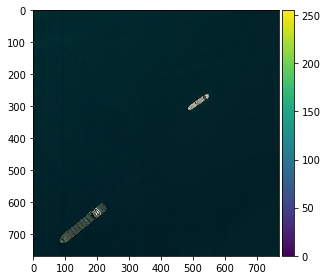

In [8]:
from skimage.io import imshow
imshow(ds[15])

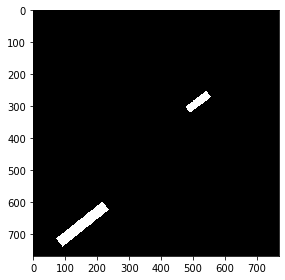

In [12]:
filename = image_ship_counts.loc[15].ImageId
total_mask = np.zeros((768, 768))
for mask in df.loc[df.ImageId == filename, 'EncodedPixels'].values:
    mask_img = utility.rle_decode(mask, shape=(768,768))
    total_mask += mask_img
    imshow(total_mask)

In [66]:
mask = np.dstack((total_mask, total_mask, total_mask)) * np.array((0, 1, 0))

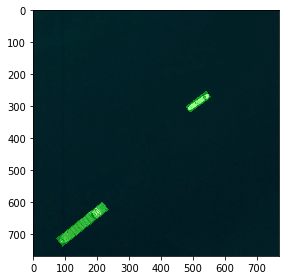

In [67]:
imshow(cv2.addWeighted(ds[15], 0.9, mask.astype('uint8')*128, 0.9, 0))